In [11]:
# Sources:
# https://github.com/sat-utils/sat-search
# https://github.com/henriod/fastApi_sentinel
#https://www.simonplanzer.com/articles/cog-ndvi-part1/
# https://github.com/cristianmurillo87/ndvi-cog-catalog
# https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/
# https://pythonawesome.com/how-to-use-cogs-cloud-optimized-geotiffs-with-rasterio/

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import shape
import json
import numpy as np
import rasterio
import geojson
import copy
import geopandas as gpd
from rasterio.plot import show, reshape_as_image
from pyproj import Transformer
from satsearch import Search

%matplotlib inline

In [12]:
# Convert to bbox
def get_bounding_box(geometry):
    coords = np.array(list(geojson.utils.coords(geometry)))
    return coords[:,0].min(), coords[:,1].min() , coords[:,0].max(), coords[:,1].max()

In [13]:
# Sentinel-2 STAC API
url = "https://earth-search.aws.element84.com/v0/"

# Cloud cover tolerances
scene_cloud_tolerance = 40 # (Variable) The % of cloud tolerated in the 100x100km Sentinel-2 scene
subset_scene_cloud_tolerance = 2 # (Variable) The % of cloud tolerated in the area of interest 

# The date range for mapping NDVI overtime
date_range = "2022-11-01/2023-01-10"

# Bounding Box delineating the spatial extent for NDVI mapping
geojson_data = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [[
           [7.163171768188476,50.01584714780868],
           [7.1739864349365225,50.01584714780868],
           [7.1739864349365225,50.01970768279515],
           [7.163171768188476,50.01970768279515],
           [7.163171768188476,50.01584714780868]
        ]]
      }
    }
  ]
}

parsed_dict = json.dumps(geojson_data)

geojson_object = geojson.loads(parsed_dict)

if geojson_object.is_valid:

  geometry = geojson_object['features'][0]['geometry']

  # convert to shapely object
  geom = shape(geometry)

  # get bounding box
  bbox = geom.bounds

  print(bbox)


(7.163172, 50.015847, 7.173986, 50.019708)


In [14]:
transform_window = None
def range_request(image_url, bbox):
    """
    Request and read just the required pixels from the COG
    """
    
    with rasterio.open(image_url) as src:
        coord_transformer = Transformer.from_crs("epsg:4326", src.crs)
        # calculate pixels to be streamed from the COG
        coord_upper_left = coord_transformer.transform(bbox[3], bbox[0])
        coord_lower_right = coord_transformer.transform(bbox[1], bbox[2])
        pixel_upper_left = src.index(coord_upper_left[0], coord_upper_left[1])
        pixel_lower_right = src.index(coord_lower_right[0], coord_lower_right[1])
         
                
        # request only the bytes in the window
        window = rasterio.windows.Window.from_slices(
            (pixel_upper_left[0], pixel_lower_right[0]),
            (pixel_upper_left[1], pixel_lower_right[1]),
        )

        # The affine transform - This will allow us to 
        # translate pixels coordiantes back to geospatial coordiantes
        transform_window = rasterio.windows.transform(window,src.transform)
        
        bands = 1
        if "TCI" in image_url: # aka True Colour Image aka RGB
            bands = [1, 2, 3]

        subset = src.read(bands, window=window)
        return(subset, transform_window)

In [15]:
def image_search(bbox, date_range, scene_cloud_tolerance):
    """
    Using SatSearch find all Sentinel-2 images
    that meet our criteria
    """
    
    search = Search(
        bbox=bbox,
        datetime=date_range,
        query={
            "eo:cloud_cover": {"lt": scene_cloud_tolerance}
        },  
        collections=["sentinel-s2-l2a-cogs"],
        url=url,
    )

    return search.items()

In [16]:
def is_cloudy(scl, tolerance):
    """
    Calculate the cloud cover in the subset-scene
    """
    
    image_size = scl.size
    unique, count = np.unique(scl, return_counts=True)
    counts = dict(zip(unique, count))

    # sum cloud types
    cloud_med_probability = counts.get(8, 0)
    cloud_high_probability = counts.get(9, 0)
    thin_cirrus = counts.get(10, 0)
    total_cloud_cover = cloud_med_probability + cloud_high_probability + thin_cirrus  
    
    # percent subscene cloud cover
    percent_cloud_cover = 100 * float(total_cloud_cover) / float(image_size)
    #print(f"Cloud cover in the subset-scene: {percent_cloud_cover}%")
    if percent_cloud_cover > tolerance:
        return True
    return False

In [17]:
def ndvi_mean(bbox, date_range, scene_cloud_tolerance):
    """
    Compute the average NDVI value
    """
    images = []

    subset_scene_cloud_tolerance = 2

    items = image_search(bbox, date_range, scene_cloud_tolerance)
    for item in items:
        
        # Refs to images
        red = item.asset("red")["href"]
        nir = item.asset("nir")["href"]
        scl = item.asset("SCL")["href"]
        date = item.date.strftime("%d/%m/%Y")
        
        # if subset_scene_cloud_tolerance is set. check for 
        # clouds in sub-scene before continuing 
        if subset_scene_cloud_tolerance:
            #print(f"Assessing Cloud Cover for {date}")
            scl_subset, transform_window = range_request(scl, bbox)
            if is_cloudy(scl_subset, subset_scene_cloud_tolerance) == 0:
                #print(f"clouds in subset-scene: {date}")

                # Streamed pixels within bbox
                red_subset, transform_window = range_request(red, bbox)
                nir_subset, transform_window = range_request(nir, bbox)

                # Calcualte NDVI
                ndvi_subset = (nir_subset.astype(float) - red_subset.astype(float)) / (
                    nir_subset + red_subset
                )

                # Calculate NDVI mean
                ndvi_gtpt0 = copy.copy(ndvi_subset)
                # Set all pixels with NDVI < 0 to nan, keeping only values > 0
                ndvi_gtpt0[ndvi_subset<0] = np.nan
                mean_NDVI=round(np.nanmean(ndvi_gtpt0),2)
                #print(item)

                # Store the data for further processing
                images.append(
                    {"Average NDVI value": mean_NDVI, "date": date,
                     "ndvi": ndvi_subset, "transform_window": transform_window}
                    )

                break

            else:

                continue
    
    return images

In [18]:
ndvi_images = ndvi_mean(bbox, date_range, scene_cloud_tolerance)

print(ndvi_images)

[{'Average NDVI value': 0.82, 'date': '23/11/2022', 'ndvi': array([[0.82151394, 0.83979328, 0.79966208, ..., 0.79670862, 0.75889724,
        0.75334018],
       [0.73199683, 0.75899844, 0.76144319, ..., 0.78192178, 0.74584801,
        0.7615009 ],
       [0.6867052 , 0.7499288 , 0.79310345, ..., 0.78512397, 0.79668908,
        0.79353493],
       ...,
       [0.84615385, 0.84107531, 0.80286904, ..., 0.87889536, 0.82817294,
        0.82821447],
       [0.84539066, 0.83210091, 0.79095164, ..., 0.8515105 , 0.81679389,
        0.8175086 ],
       [0.84218715, 0.81522259, 0.75997687, ..., 0.8649487 , 0.85281811,
        0.83183183]]), 'transform_window': Affine(10.0, 0.0, 798190.0,
       0.0, -10.0, 5549140.0)}]


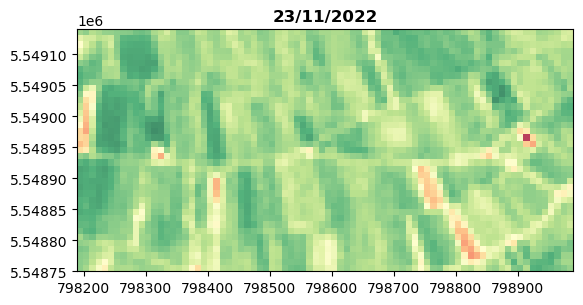

In [19]:
# Visualise NDVI

for plot in zip(ndvi_images):
    image = plot[0]
    rgb_axes = show(image['ndvi'], 
                    transform = image['transform_window'], 
                    alpha = 0.75,
                    cmap = "RdYlGn", 
                    title = image["date"])
    # show full y-coords
    rgb_axes.ticklabel_format(style ='plain')

In [20]:
file = "/Users/diego.alarcon/fastAPI_up42/assets/map.geojson"

# with open(file) as f:
#     gj = geojson.load(f)
#     #features = gj['features'][0]

# if gj.is_valid:

#   geometry = gj['features'][0]['geometry']

#   # convert to shapely object
#   geom = shape(geometry)

#   # get bounding box
#   bbox = geom.bounds

#   print(bbox)

##################################

parsed_dict = geojson.dumps(file)

geojson_object = geojson.loads(parsed_dict)

#print(geojson_object)

polygons_gdf = gpd.read_file(file)
#print(polygons_gdf)

geo_shapes = []

for geo_shape in polygons_gdf.geometry.values:
    geo_shapes.append(geo_shape)
    #print(type(geo_shapes))
    #print(geo_shapes[0])

if geo_shapes[0].is_valid:

    # convert to shapely object
    geom2 = shape(geo_shapes[0])

    # get bounding box
    bbox2 = geom2.bounds
    print(bbox2)

(7.163171768188476, 50.01584714780868, 7.1739864349365225, 50.01970768279515)
